In [1]:
from mip import *
import numpy as np
import pandas as pd 
import numpy.random as npr
import scipy.special
from collections import Counter
import sys, string, itertools, copy, time

In [2]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

solver_name = "CBC" # If you have GRB installed change to GRB would be faster

## Toy example as used in Figure 1

In [3]:
# Helper functions 
# Output binary representation of all b choose k
def for_all_point_nr(k, b):
	# { (y_1...y_P) \in {0,1}^P | y_1 + ... + y_P == C, y_i >= 0 }
	def dfs(now, i, r):
		if r == 0:
			yield now
		elif i < b:
			for x in range( min(2, r+1) ):
				now[i] = x
				for tmp in dfs(now, i + 1, r - x):
					yield tmp
			now[i] = 0
	for x in dfs([0] * b, 0, k):
		yield x

# Build a graph where each vertex is a pooling profile (potential donor)
# and each edge represents a pair of profiles that cannot co-exist
def build_graph(k,b,c):
	Vset = []
	id = 0
	for v in for_all_point_nr(k,b):
		Vset.append([id, 0, v.copy(),[]])
		id += 1
	print("Number of notes %d" % id)
	for i in range(1, id):
		for j in range(i):
			dis = len([x for x in range(b) if Vset[i][2][x] != Vset[j][2][x] ])
			if dis < c: #
				Vset[i][1] += 1; # Number of neighbors to avoid
				Vset[i][3].append(j) # Neighbors' id (not safe for co-occurence)
				Vset[j][1] += 1;
				Vset[j][3].append(i)
	return Vset

In [4]:
N = 20 # Number of individuals (donors)
P = 6  # Number of pools 
C = 3  # Number of experimental conditions 
colorset = ['#57A3AD', '#DEA73A', '#D92120']

In [5]:
# Most compact design 
f = "./example/N20_P6_C3_m2.design"
with open(f, 'r') as rf:
    lines = rf.readlines()
code = [x.strip().split(' ') for x in lines]
P = len(code)
code_mat = []
for i in range(P):
    code_mat.append([0]*N)
    for j in range(N):
        if code[i][j] == ".":
            code_mat[i][j] = 0
        else:
            code_mat[i][j] = ord(code[i][j])-96

code_df = pd.DataFrame(code_mat)

Text(80.5, 0.5, 'Pools')

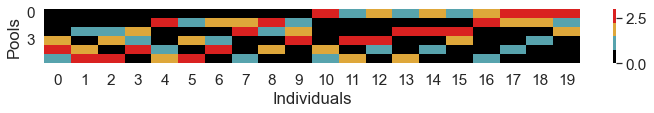

In [6]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12,1))
ax = sns.heatmap(code_df, cmap=['#000000']+colorset)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.xlabel('Individuals')
plt.ylabel('Pools')

In [7]:
arr = (np.array(code_mat) > 0).astype(int)
overlap = np.dot(arr.transpose(),arr)
ovec = overlap[np.triu_indices(N, 1)].reshape(-1,1).squeeze()
ct = Counter(ovec)
tab = [0] * C
for k,v in ct.items():
    tab[k] = v

print(f"Spectrum of pairwise overlaps:")
out = ["%d:%d" % (i,x) for i,x in enumerate(tab)]
print('\t'.join(out))
print(f"Total pairwise overlaps: {ovec.sum()}")

Spectrum of pairwise overlaps:
0:10	1:90	2:90
Total pairwise overlaps: 270


In [8]:
# Robust design 
f = "./example/N20_P12_C3_m4.design"
with open(f, 'r') as rf:
    lines = rf.readlines()
code = [x.strip().split(' ') for x in lines]
P = len(code)
code_mat = []
for i in range(P):
    code_mat.append([0]*N)
    for j in range(N):
        if code[i][j] == ".":
            code_mat[i][j] = 0
        else:
            code_mat[i][j] = ord(code[i][j])-96

code_df = pd.DataFrame(code_mat)

Text(80.5, 0.5, 'Pools')

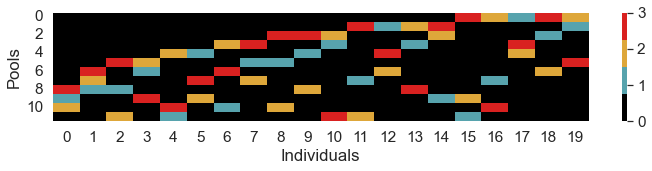

In [9]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12,2))
ax = sns.heatmap(code_df, cmap=['#000000']+colorset)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.xlabel('Individuals')
plt.ylabel('Pools')

In [10]:
arr = (np.array(code_mat) > 0).astype(int)
overlap = np.dot(arr.transpose(),arr)
ovec = overlap[np.triu_indices(N, 1)].reshape(-1,1).squeeze()
ct = Counter(ovec)
tab = [0] * C
for k,v in ct.items():
    tab[k] = v

print(f"Spectrum of pairwise overlaps:")
out = ["%d:%d" % (i,x) for i,x in enumerate(tab)]
print('\t'.join(out))
print(f"Total pairwise overlaps: {ovec.sum()}")

Spectrum of pairwise overlaps:
0:70	1:120	2:0
Total pairwise overlaps: 120


In [11]:
# code_mat = []
# for i in range(N*C):
#     code_mat.append([0]*N)
# for i in range(C):
#     for j in range(N):
#         code_mat[i*N+j][j] = i+1

# code_df = pd.DataFrame(code_mat)
# sns.set(font_scale=1.4)
# plt.figure(figsize=(12,10))
# ax = sns.heatmap(code_df, cmap=['#000000']+colorset)
# ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
# plt.xlabel('Individuals')
# plt.ylabel('Pools')

## The graph used to illustrate the robustness formulation in Figure S1

In [12]:
P = 6  # Number of pools 
C = 3  # Number of experimental conditions 
m = 4  # Minimum pairwise difference between the pool assignments of donors
max_threads = 1
max_sec = 300
code_length = 1
letters = list(string.ascii_letters)
ccode = letters

In [13]:
tot = int(scipy.special.comb(P, C))
Vset = build_graph(C,P,m)
N = len(Vset)
ilp = Model(solver_name=solver_name)
ilp.verbose = 0
ilp.threads = max_threads
x = [ ilp.add_var(var_type=BINARY) for i in range(N) ]
for i in range(N):
    for j in Vset[i][3]:
        if j < i:
            ilp += xsum( [x[i], x[j] ] ) <= 1
ilp.objective = maximize(xsum( x[i] for i in range(N) ) )
status = ilp.optimize()
n_sol = ilp.num_solutions
candidates = [Vset[i][2] for i,x in enumerate(ilp.vars) if x.xi(0) == 1. ]
N = len(candidates)

Number of notes 20


In [14]:
code_mat = [ Vset[i][2] for i in range(len(Vset)) ]
code_df = pd.DataFrame(np.transpose(code_mat))

edgelist = [ [ (x[0], y) for y in x[3] ] for x in Vset ]
edgelist = [ y for x in edgelist for y in x ]

In [15]:
V = len(Vset)
G = nx.Graph()
G.add_node(range(V))
G.add_edges_from(edgelist)
pos = nx.spring_layout(G)

In [16]:
MIS = set([Vset[i][0] for i,x in enumerate(ilp.vars) if x.xi(0) == 1. ])
other = [ i for i in range(V) if i not in MIS ]
label = [ 1 if x in MIS else 2 for x in range(len(Vset)) ]

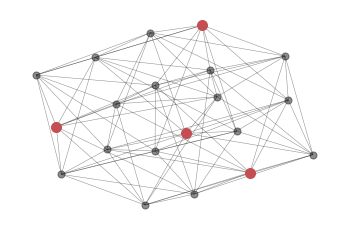

In [17]:
mpl.rcParams["axes.facecolor"] = 'white'
nx.draw_networkx_nodes(G, pos,
                       nodelist=other,
                       node_color='k',
                       node_size=50,
                       alpha=0.5)
nx.draw_networkx_nodes(G, pos,
                       nodelist=MIS,
                       node_color='r',
                       node_size=100,
                       alpha=1)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

## Robustness comparison in the 64 individual case

The logarithmic design

In [18]:
N = 64 # number of individuals
C = 6  # Conditions 
# Logarithmic
code_mat = []
for n in range(N):
    ind_code = ('{0:0%sb}' % int(np.log2(N))).format(n)
    ls_code = [int(x) for x in str(ind_code)]
    # complementary (orthogonal vector)
    ls_code.extend([(x-1)**2 for x in ls_code])
    code_mat.append(ls_code)
code_df = pd.DataFrame(np.transpose(code_mat))

In [19]:
arr = (np.array(code_mat) > 0).astype(int).T
overlap = np.dot(arr.transpose(),arr)
ovec = overlap[np.triu_indices(N, 1)].reshape(-1,1).squeeze()
ct = Counter(ovec)
tab = [0] * C
for k,v in ct.items():
    tab[k] = v

print(f"Spectrum of pairwise overlaps:")
out = ["%d:%d" % (i,x) for i,x in enumerate(tab)]
print('\t'.join(out))
print(f"Total pairwise overlaps: {ovec.sum()}")

Spectrum of pairwise overlaps:
0:32	1:192	2:480	3:640	4:480	5:192
Total pairwise overlaps: 5952


Pairs of donors that co-exist in 5 pools are most likely to be mistaken

The most efficient design

In [20]:
P=9
f = "./example/N64_P9_C6_m2.design"
with open(f, 'r') as rf:
    lines = rf.readlines()
code = [x.strip().split(' ') for x in lines]    
code_mat = []
for i in range(P):
    code_mat.append([0]*N)
    for j in range(N):
        if code[i][j] == ".":
            code_mat[i][j] = 0
        else:
            code_mat[i][j] = 1

In [21]:
arr = (np.array(code_mat) > 0).astype(int)
overlap = np.dot(arr.transpose(),arr)
ovec = overlap[np.triu_indices(N, 1)].reshape(-1,1).squeeze()
ct = Counter(ovec)
tab = [0] * C
for k,v in ct.items():
    tab[k] = v

print(f"Spectrum of pairwise overlaps:")
out = ["%d:%d" % (i,x) for i,x in enumerate(tab)]
print('\t'.join(out))
print(f"Total pairwise overlaps: {ovec.sum()}")

Spectrum of pairwise overlaps:
0:0	1:0	2:0	3:482	4:1114	5:420
Total pairwise overlaps: 8002


The most efficient design achieving higher robustness: all pairs of donors differ by at least 4 pools

In [22]:
P=11
f = "./example/N64_P11_C6_m4.design"
with open(f, 'r') as rf:
    lines = rf.readlines()
code = [x.strip().split(' ') for x in lines]    
code_mat = []
for i in range(P):
    code_mat.append([0]*N)
    for j in range(N):
        if code[i][j] == ".":
            code_mat[i][j] = 0
        else:
            code_mat[i][j] = 1

In [23]:
arr = (np.array(code_mat) > 0).astype(int)
overlap = np.dot(arr.transpose(),arr)
ovec = overlap[np.triu_indices(N, 1)].reshape(-1,1).squeeze()
ct = Counter(ovec)
tab = [0] * C
for k,v in ct.items():
    tab[k] = v

print(f"Spectrum of pairwise overlaps:")
out = ["%d:%d" % (i,x) for i,x in enumerate(tab)]
print('\t'.join(out))
print(f"Total pairwise overlaps: {ovec.sum()}")

Spectrum of pairwise overlaps:
0:0	1:0	2:465	3:621	4:930	5:0
Total pairwise overlaps: 6513


Note that none of the pairs co-exist in 5 pools